In [ ]:
# Importing necessary libraries
import numpy as np                      # For numerical operations (arrays, random numbers, etc.)
import torch                            # Main PyTorch library
import torch.nn as nn                   # Neural network components (layers, activations)
import torch.optim as optim             # Optimization algorithms like SGD
from sklearn.datasets import load_breast_cancer  # Built-in breast cancer dataset from sklearn
from sklearn.model_selection import train_test_split  # To split data into training and test sets
from sklearn.preprocessing import StandardScaler      # For normalizing the feature values
from sklearn.metrics import accuracy_score            # To calculate accuracy after predictions
import pandas as pd                    # For handling tabular data (saving results to CSV)
import matplotlib.pyplot as plt        # For plotting graphs
from torch.utils.data import DataLoader, TensorDataset  # For loading data in batches
import time                            # To track training time
import psutil                          # For checking memory usage
import os                              # To interact with the operating system (used by psutil)

# Function to print current memory usage (useful for tracking resource usage during training)
def print_memory_usage(label=""):
    process = psutil.Process(os.getpid())             # Get current Python process
    mem_mb = process.memory_info().rss / 1024 / 1024  # Get memory in MB
    print(f"[{label}] RAM usage: {mem_mb:.2f} MB")     # Print RAM usage with custom label

# Set random seeds for reproducibility (same results each time you run the code)
torch.manual_seed(42)
np.random.seed(42)

# Print the version of NumPy for debugging/logging purposes
print(f"NumPy version: {np.__version__}")


NumPy version: 1.26.4


In [ ]:
#Neural Network Definition

# Define a custom neural network using PyTorch
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, hidden_activation='tanh'):
        super(NeuralNetwork, self).__init__()  # Call the parent constructor (nn.Module)

        self.layers = nn.ModuleList()          # Use ModuleList to dynamically build layers
        prev_size = input_size                 # Start with the input size

        # Add hidden layers one by one
        for hidden_size in hidden_sizes:
            self.layers.append(nn.Linear(prev_size, hidden_size))  # Add a linear layer
            prev_size = hidden_size                                 # Update the previous size

        # Add the final output layer
        self.layers.append(nn.Linear(prev_size, output_size))

        # Choose hidden activation function: Tanh or ReLU
        self.hidden_activation = nn.Tanh() if hidden_activation == 'tanh' else nn.ReLU()

        # Output activation is always Sigmoid (since this is binary classification)
        self.output_activation = nn.Sigmoid()
        
        # Initialize weights of each layer
        for layer in self.layers:
            if isinstance(layer, nn.Linear):  # Apply only to linear layers
                if hidden_activation == 'relu':
                    nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')  # Best for ReLU
                else:
                    nn.init.xavier_normal_(layer.weight)                        # Best for Tanh
        # Define how the input flows through the network
    def forward(self, x):
        for layer in self.layers[:-1]:                # Apply hidden layers
            x = self.hidden_activation(layer(x))      # Apply chosen activation function
        x = self.output_activation(self.layers[-1](x))  # Apply output layer with sigmoid
        return x



In [ ]:
#  Training and Evaluation Function

def preprocess_and_train(X, y, input_size, output_size, hidden_sizes, hidden_activation='tanh', epochs=10000, lr=0.01, batch_size=32):
    #  Split the data into 80% training and 20% test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #  Normalize the features using StandardScaler (mean=0, std=1)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    #  Convert the NumPy arrays into PyTorch tensors
    X_train = torch.FloatTensor(X_train)
    X_test = torch.FloatTensor(X_test)
    y_train = torch.LongTensor(y_train)
    y_test = torch.LongTensor(y_test)

    #  Create a dataset and a DataLoader to allow mini-batch training
    dataset = TensorDataset(X_train, y_train)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize the neural network model with the given configuration
    model = NeuralNetwork(input_size, hidden_sizes, output_size, hidden_activation)

    #  Use cross-entropy loss for classification
    criterion = nn.CrossEntropyLoss()

    #  Use Stochastic Gradient Descent (SGD) as the optimizer
    optimizer = optim.SGD(model.parameters(), lr=lr)

    # Print RAM usage before training starts
    print_memory_usage("Before Training")

    #  Start timer to measure training duration
    start_time = time.time()

    #  Begin training phase
    model.train()
    for epoch in range(epochs):
        for X_batch, y_batch in dataloader:
            optimizer.zero_grad()               # Reset gradients
            outputs = model(X_batch)            # Forward pass
            loss = criterion(outputs, y_batch)  # Compute loss
            loss.backward()                     # Backward pass
            optimizer.step()                    # Update weights
        if epoch % 1000 == 0:                   # Print loss every 1000 epochs
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

    # Stop timer and calculate total training time
    end_time = time.time()
    elapsed_minutes = (end_time - start_time) / 60
    print_memory_usage("After Training")
    print(f"Training Time: {elapsed_minutes:.2f} minutes")

    #  Evaluation phase (no gradient tracking needed)
    model.eval()
    with torch.no_grad():
        # Evaluate on training data
        train_outputs = model(X_train)
        _, train_predicted = torch.max(train_outputs, 1)
        train_accuracy = accuracy_score(y_train.cpu().numpy(), train_predicted.cpu().numpy())
        print(f"Training Accuracy: {train_accuracy:.4f}")

        #  Evaluate on test data
        test_outputs = model(X_test)
        _, test_predicted = torch.max(test_outputs, 1)
        test_accuracy = accuracy_score(y_test.cpu().numpy(), test_predicted.cpu().numpy())
        print(f"Test Accuracy: {test_accuracy:.4f}")

    # Count total parameters and estimate RAM usage (4 bytes per param)
    total_params = sum(p.numel() for p in model.parameters())
    estimated_ram = total_params * 4
    print(f"Total Parameters: {total_params}, Estimated RAM: {estimated_ram} bytes")

    #  Return evaluation metrics
    return train_accuracy, test_accuracy, total_params, estimated_ram, elapsed_minutes


In [ ]:
# Load Dataset

# Load the Breast Cancer dataset from scikit-learn
breast_cancer = load_breast_cancer()

# Separate features (X) and labels (y)
X_bc, y_bc = breast_cancer.data, breast_cancer.target

# Determine input size (number of features)
input_size_bc = X_bc.shape[1]

# Determine output size (number of classes, e.g., 2 for binary classification)
output_size_bc = len(np.unique(y_bc))

# Print basic info about the dataset: number of samples, features, and classes
print(f"Breast Cancer Dataset: {X_bc.shape[0]} samples, {input_size_bc} features, {output_size_bc} classes")


Breast Cancer Dataset: 569 samples, 30 features, 2 classes


In [ ]:
#  Experiment Configurations

# Define a list of different neural network configurations to test
# Each configuration changes the number of hidden layers, the number of neurons, and the activation function
configurations = [
    {'hidden_sizes': [5, 5], 'hidden_activation': 'tanh'},       # 2 hidden layers with 5 neurons each, using Tanh
    {'hidden_sizes': [5, 5], 'hidden_activation': 'relu'},       # 2 hidden layers with 5 neurons each, using ReLU
    {'hidden_sizes': [10, 10], 'hidden_activation': 'tanh'},     # 2 hidden layers with 10 neurons each, using Tanh
    {'hidden_sizes': [10, 10], 'hidden_activation': 'relu'},     # 2 hidden layers with 10 neurons each, using ReLU
    {'hidden_sizes': [10, 10, 10], 'hidden_activation': 'tanh'}, # 3 hidden layers with 10 neurons each, using Tanh
    {'hidden_sizes': [10, 10, 10], 'hidden_activation': 'relu'}, # 3 hidden layers with 10 neurons each, using ReLU
]


In [ ]:
# Run Experiments with Different Configurations

# Create an empty list to store the results for each configuration
results = []

# Loop through each configuration (with index starting at 1)
for i, config in enumerate(configurations, 1):
    # Print which configuration is being tested
    print(f"\nTesting Configuration {i}: {config['hidden_sizes']} neurons, {config['hidden_activation']} activation")

    # Set different learning rate and epochs for the last configuration (to test smaller lr and longer training)
    lr = 0.001 if i == 6 else 0.01
    epochs = 2000 if i == 6 else 1000

    # Call the training function with the current configuration
    train_acc, test_acc, params, ram, elapsed = preprocess_and_train(
        X_bc, y_bc, input_size_bc, output_size_bc,
        hidden_sizes=config['hidden_sizes'],
        hidden_activation=config['hidden_activation'],
        epochs=epochs,
        lr=lr,
        batch_size=32
    )

    # Save the results from this configuration into a dictionary and add it to the results list
    results.append({
        'configuration': f"Config {i}",
        'hidden_sizes': config['hidden_sizes'],
        'hidden_activation': config['hidden_activation'],
        'train_accuracy': train_acc,
        'test_accuracy': test_acc,
        'params': params,
        'ram_bytes': ram,
        'time_minutes': elapsed
    })



Testing Configuration 1: [5, 5] neurons, tanh activation
[Before Training] RAM usage: 319.69 MB
Epoch 0, Loss: 0.6579
[After Training] RAM usage: 324.18 MB
Training Time: 0.74 minutes
Training Accuracy: 0.9868
Test Accuracy: 0.9737
Total Parameters: 197, Estimated RAM: 788 bytes

Testing Configuration 2: [5, 5] neurons, relu activation
[Before Training] RAM usage: 324.12 MB
Epoch 0, Loss: 0.7057
[After Training] RAM usage: 324.24 MB
Training Time: 0.61 minutes
Training Accuracy: 0.9890
Test Accuracy: 0.9737
Total Parameters: 197, Estimated RAM: 788 bytes

Testing Configuration 3: [10, 10] neurons, tanh activation
[Before Training] RAM usage: 324.20 MB
Epoch 0, Loss: 0.7237
[After Training] RAM usage: 324.27 MB
Training Time: 0.94 minutes
Training Accuracy: 0.9890
Test Accuracy: 0.9825
Total Parameters: 442, Estimated RAM: 1768 bytes

Testing Configuration 4: [10, 10] neurons, relu activation
[Before Training] RAM usage: 324.32 MB
Epoch 0, Loss: 0.6816
[After Training] RAM usage: 324.3

In [ ]:
#  Display and Save Results from All Experiments

# Print a summary of each configuration’s results
print("\nGrid Search Results:")
for result in results:
    print(f"Configuration: {result['configuration']}, "
          f"Hidden Sizes: {result['hidden_sizes']}, "
          f"Activation: {result['hidden_activation']}, "
          f"Train Accuracy: {result['train_accuracy']:.4f}, "
          f"Test Accuracy: {result['test_accuracy']:.4f}, "
          f"Params: {result['params']}, "
          f"RAM: {result['ram_bytes']} bytes, "
          f"Time: {result['time_minutes']:.2f} min")

# Convert the results list into a DataFrame (like a table)
df = pd.DataFrame(results)

# Save the DataFrame to a CSV file for later analysis or reporting
df.to_csv("pytorch_breast_cancer_results.csv", index=False)

# Confirm the save location
print("Results saved to 'pytorch_breast_cancer_results.csv'")



Grid Search Results:
Configuration: Config 1, Hidden Sizes: [5, 5], Activation: tanh, Train Accuracy: 0.9868, Test Accuracy: 0.9737, Params: 197, RAM: 788 bytes, Time: 0.74 min
Configuration: Config 2, Hidden Sizes: [5, 5], Activation: relu, Train Accuracy: 0.9890, Test Accuracy: 0.9737, Params: 197, RAM: 788 bytes, Time: 0.61 min
Configuration: Config 3, Hidden Sizes: [10, 10], Activation: tanh, Train Accuracy: 0.9890, Test Accuracy: 0.9825, Params: 442, RAM: 1768 bytes, Time: 0.94 min
Configuration: Config 4, Hidden Sizes: [10, 10], Activation: relu, Train Accuracy: 0.9890, Test Accuracy: 0.9912, Params: 442, RAM: 1768 bytes, Time: 0.55 min
Configuration: Config 5, Hidden Sizes: [10, 10, 10], Activation: tanh, Train Accuracy: 0.9912, Test Accuracy: 0.9825, Params: 552, RAM: 2208 bytes, Time: 0.76 min
Configuration: Config 6, Hidden Sizes: [10, 10, 10], Activation: relu, Train Accuracy: 0.9736, Test Accuracy: 0.9737, Params: 552, RAM: 2208 bytes, Time: 0.97 min
Results saved to 'pyto

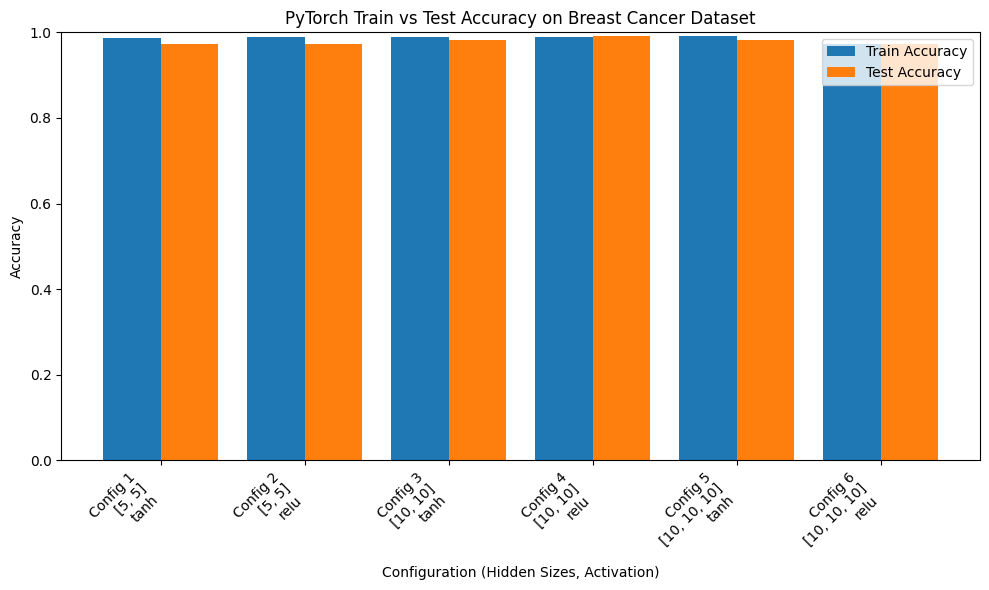

Plot saved as 'pytorch_breast_cancer_accuracy_plot.png'


In [ ]:
# Plotting Train vs Test Accuracy for Each Configuration

# Create custom x-axis labels showing configuration number, hidden layer sizes, and activation function
configs = [f"Config {i+1}\n{r['hidden_sizes']}\n{r['hidden_activation']}" for i, r in enumerate(results)]

# Extract training accuracies from results
train_accuracies = [r['train_accuracy'] for r in results]

# Extract test accuracies from results
test_accuracies = [r['test_accuracy'] for r in results]

# Set the figure size for the plot
plt.figure(figsize=(10, 6))

# Create x-axis positions for each bar group
x = np.arange(len(configs))

# Draw bar chart for training accuracy (left bars)
plt.bar(x - 0.2, train_accuracies, 0.4, label='Train Accuracy')

# Draw bar chart for test accuracy (right bars)
plt.bar(x + 0.2, test_accuracies, 0.4, label='Test Accuracy')

# Label the x-axis
plt.xlabel('Configuration (Hidden Sizes, Activation)')

# Label the y-axis
plt.ylabel('Accuracy')

# Set the plot title
plt.title('PyTorch Train vs Test Accuracy on Breast Cancer Dataset')

# Set x-axis tick labels to the configuration names
plt.xticks(x, configs, rotation=45, ha='right')

# Add legend to distinguish train/test bars
plt.legend()

# Set y-axis limits from 0 to 1 (100%)
plt.ylim(0, 1)

# Adjust layout so labels don’t get cut off
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig("pytorch_breast_cancer_accuracy_plot.png")

# Show the plot on screen
plt.show()

# Confirm the file was saved
print("Plot saved as 'pytorch_breast_cancer_accuracy_plot.png'")
